# Prédiction de la demande en électricité sur le marché français

*Etude data - Projet 9 - Nalron (Mai 2020)*\
*OpenClassrooms - ENSAE-ENSAI Formation continue*

*Traitement des données sur Jupyter Notebook (Distribution Anaconda)*\
*Etude réalisée en langage Python*

*Data source*\
[Données mensuelles de consommation totale d'électricité en énergie](http://www.rte-france.com/fr/eco2mix/eco2mix-telechargement)\
[Données météo pour corriger l'effet température](https://cegibat.grdf.fr/simulateur/calcul-dju)

*Les consommations en électricité sont exprimées en Gigawatt (GWh).* 

---

## Prévision de la consommation (corrigée de l'effet température) sur un an

La phase de prédition se fera en utilisant la méthode de Holt-Winters (lissage exponentiel) puis la méthode SARIMA.

### Prévision à l'aide du lissage exponentiel par la méthode de Holt-Winters

La méthode ExponentialSmoothing de statsmodels est utilisée pour modéliser le lissage exponentiel d'Holt-Winters.

In [40]:
from statsmodels.tsa.api import ExponentialSmoothing

y = np.asarray(df["conso_corr"])
hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

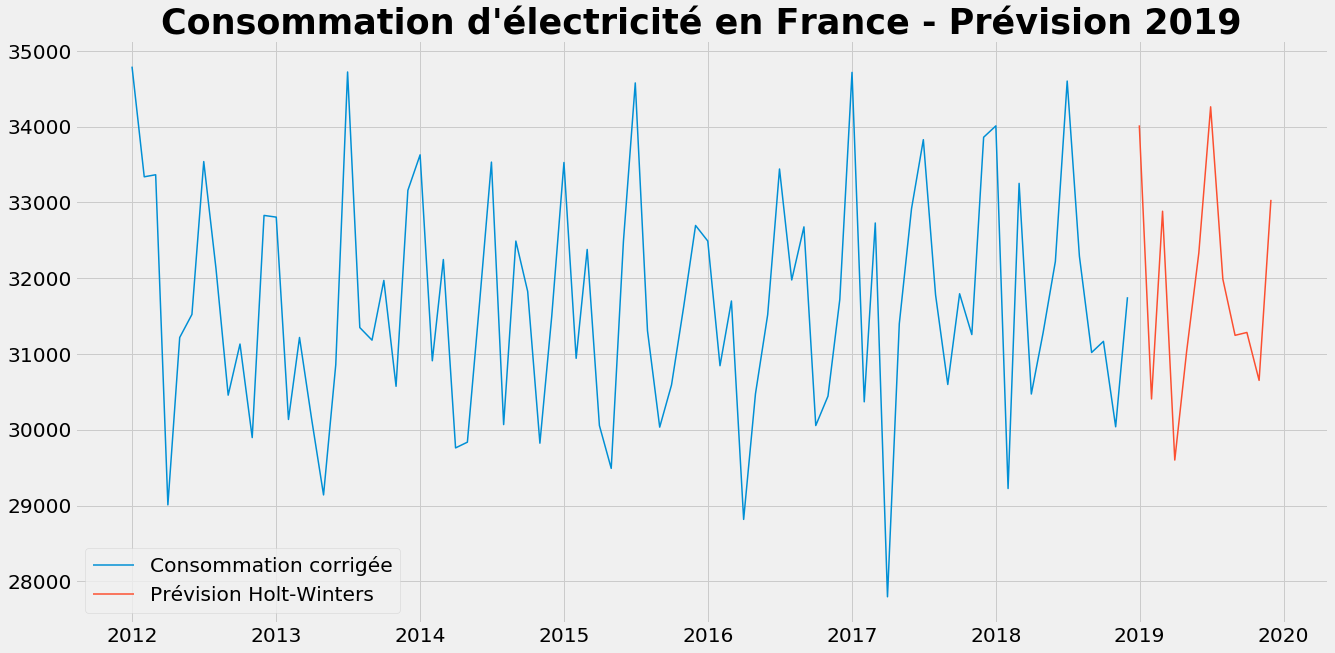

In [41]:
#Visualisation de la prévision à 12 mois par Holt-Winters
plt.plot(df["conso_corr"], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France - Prévision 2019")

plt.savefig("p9_graphic/prevision2019_holt-winters.png")
plt.legend()
plt.show()

La méthode de Holt-Winters est la plus raisonnable des méthodes de lissage exponentiel. La prévision sur un an de la consommation, corrigée de l'effet température, tient compte de la saisonnalité. Ci-dessous une visualisation par restriction sur la période 2018/2019.

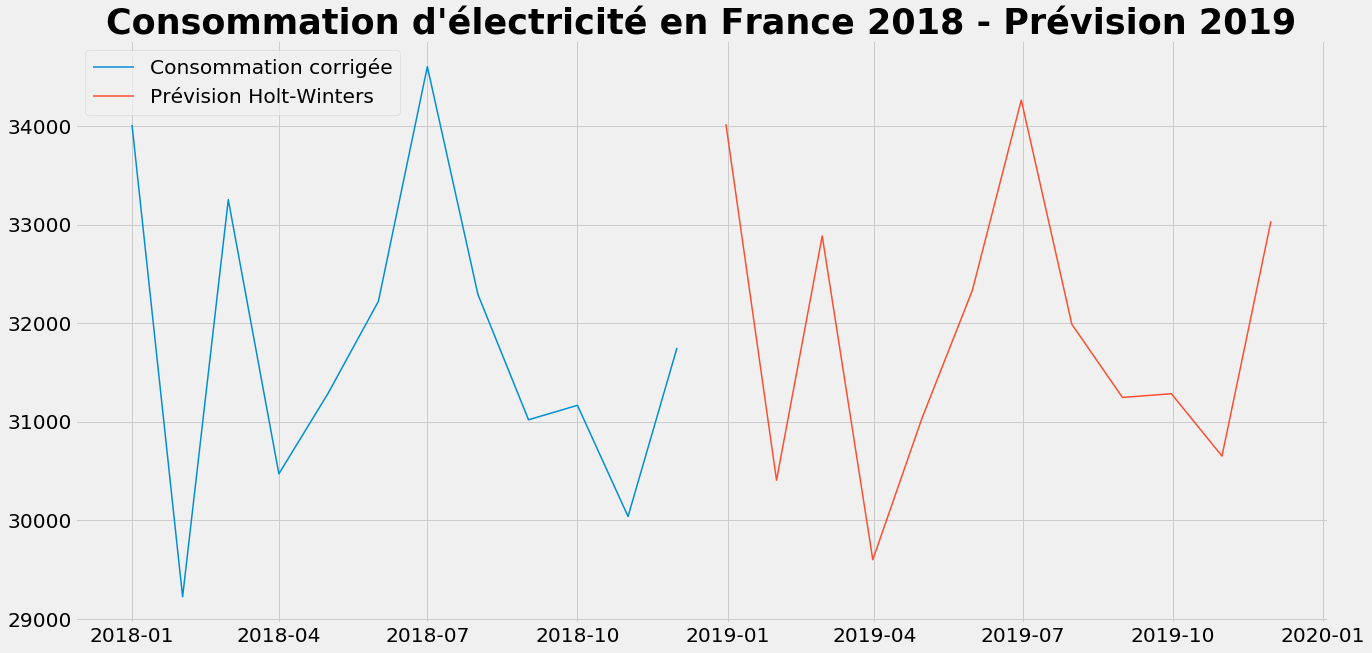

In [42]:
#Visualisation par restriction sur l'année de prévision et n-1 (2018/2019)
plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France 2018 - Prévision 2019")
        
plt.legend()
plt.savefig("p9_graphic/prevision_visu20182019_holt-winters.png")
plt.show()

### Analyse a posteriori
On tronque la série de l’année 2018, qu’on cherche ensuite à prévoir à partir de l’historique 2012-2017. Cette analyse permet d'avoir une idée de la qualité prédictive du modèle choisi.

In [43]:
#Troncature des données sur les années 2017 et 2018
df_tronc = df[:'2017']
x_prevision = df['2018':]

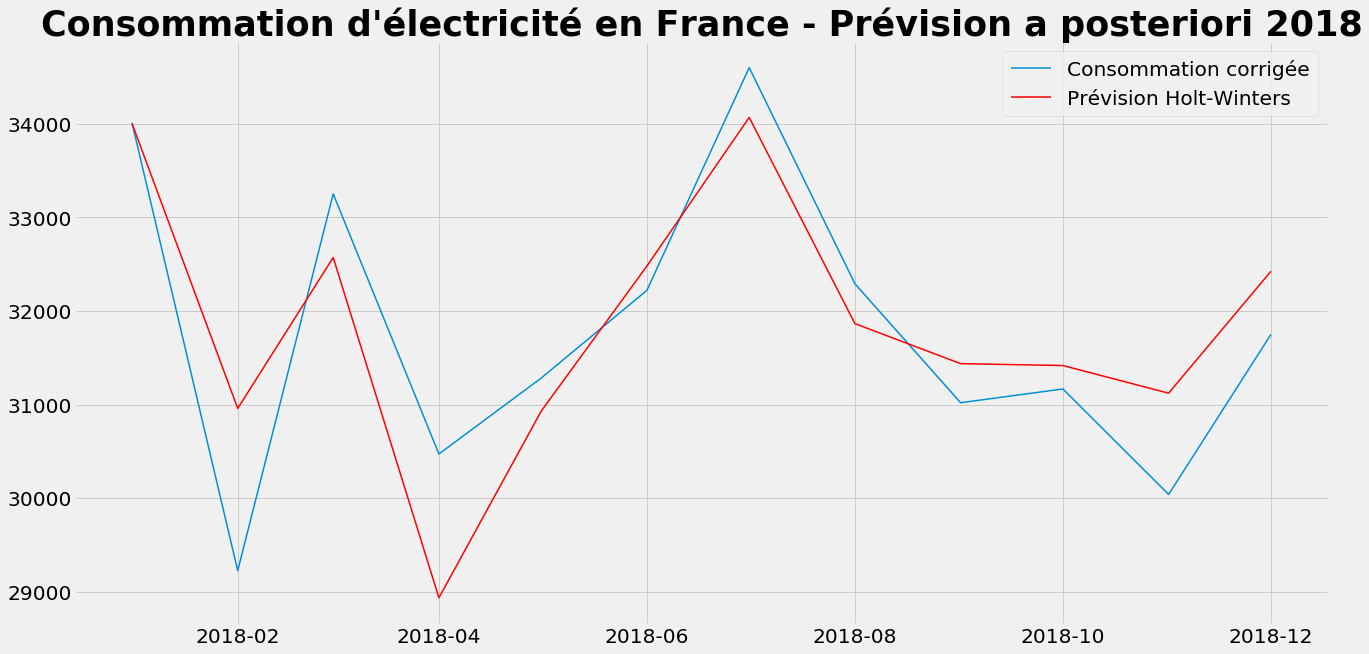

In [44]:
#Visualisation par restriction sur l'année 2018
y = df_tronc["conso_corr"]

hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(x_prevision.index, hw_pred, color='r', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France - Prévision a posteriori 2018")

plt.savefig("p9_graphic/prevision_visu20182019_holt-winters_aposteriori.png")
plt.legend()
plt.show()

Par les chiffres nous pouvons calculer le **MAPE (Mean Absolute Percentage)**. L’erreur absolue moyenne en pourcentage, en d'autres termes la moyenne des écarts en valeur absolue par rapport aux valeurs observées.

In [45]:
#Calcul du MAPE
mape = round((np.abs(1-hw_pred/x_prevision["conso_corr"])).mean()*100, 2)
mape

2.14

Une analyse a posteriori sur 24 mois peut également être appliquée pour déterminer d'éventuelles limites prédictives.

In [46]:
#Troncature des données pour une prévision a posteriori de 24 mois
df_tronc = df[:'2016']
x_prevision = df['2017':]

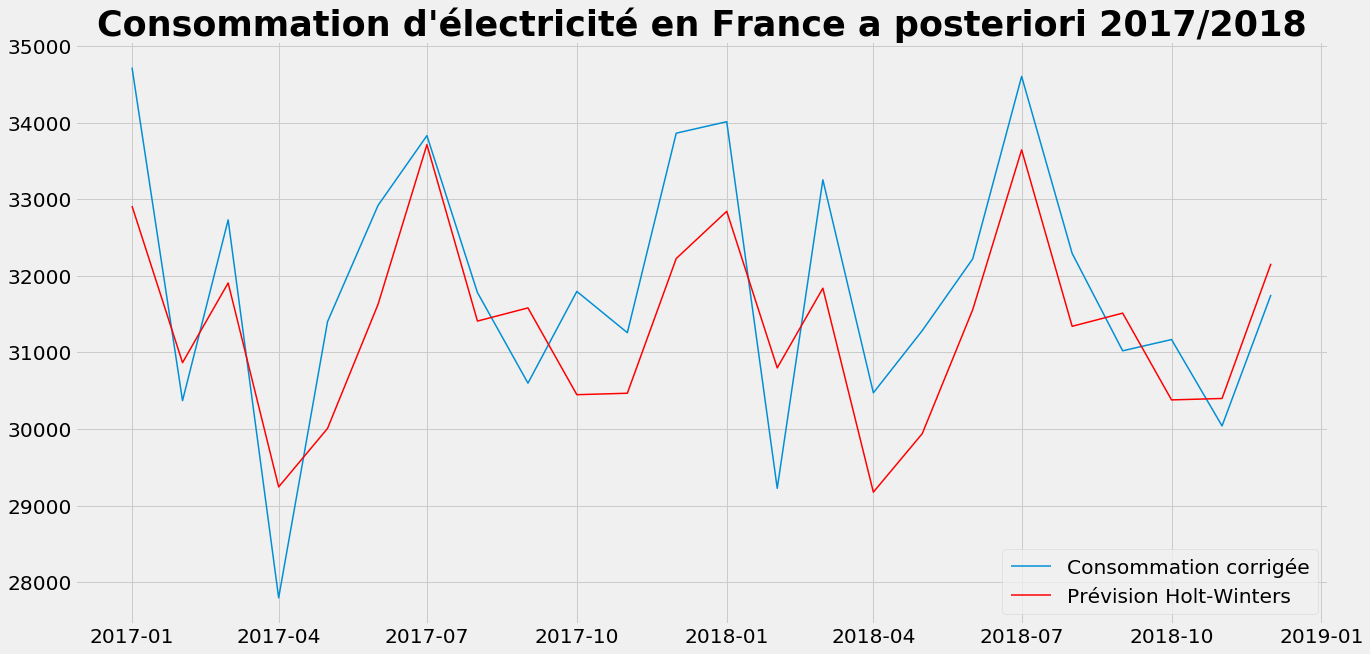

In [47]:
#Visualisation par restriction sur les années de prévision 2017 et 2018
y = df_tronc["conso_corr"]

hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(24)

plt.plot(df["conso_corr"].iloc[-24:], label='Consommation corrigée')
plt.plot(x_prevision.index, hw_pred, color='r', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France a posteriori 2017/2018")

plt.savefig("p9_graphic/prevision_visu20172018_holt-winters_aposteriori.png")
plt.legend()
plt.show()

In [48]:
#Calcul du MAPE
mape = round((np.abs(1-hw_pred/x_prevision["conso_corr"])).mean()*100, 2)
print("MAPE :" + str(mape))

MAPE :3.14


Cet indicateur nous permettra d'établir une comparaison avec les futures prévisions, et nous pourrons arrêter notre choix sur le modèle le plus performant. Dans l'immédiat, l'analyse a posteriori doublée sur 24 mois permet de penser que le modèle résiste plutôt bien aux impacts saisonniers sur du long terme. Ceci étant, les excédents des pics et creux ne sont pas totalement prévisibles par le modèle, les prévisions SARIMA seront-elles plus représentatives des variations de charge électrique?

### Prévision à l'aide d'un modèle ARIMA saisonnier de format : SARIMA(p,d,q)(P,D,Q)(t)

Plusieurs étapes sont nécessaires :
1. Identifier/confirmer la saisonnalité s (autocorrélogrammes)
2. Stationnariser la série temporelle (différenciation)
3. Déterminer des ordres optimaux plausibles
4. Estimer les paramètres et les départager par l’AIC (ou le BIC)
5. Valider ou non le modèle par un diagnostique des résidus (test, représentation graphique, autocorrélogramme)
6. Confirmer le(s) choix en simulant la prévision.

### Stationnarité et différenciation de la série :

Nous sommes en présence d'une série temporelle marquée par une forte saisonnalité, très classique sur les températures climatiques. Il n'est pas possible de modéliser directement par un processus stationnaire, la stationnarisation du processus sera donc mise en oeuvre. La méthode retenue sera la différenciation.

In [49]:
#Fonction affichant le Test de Dickey–Fuller avec les autocorrélogrammes ACF et PACF
def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    """
        Test de Dickey–Fuller 
        avec Autocorrélogrammes ACF et PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

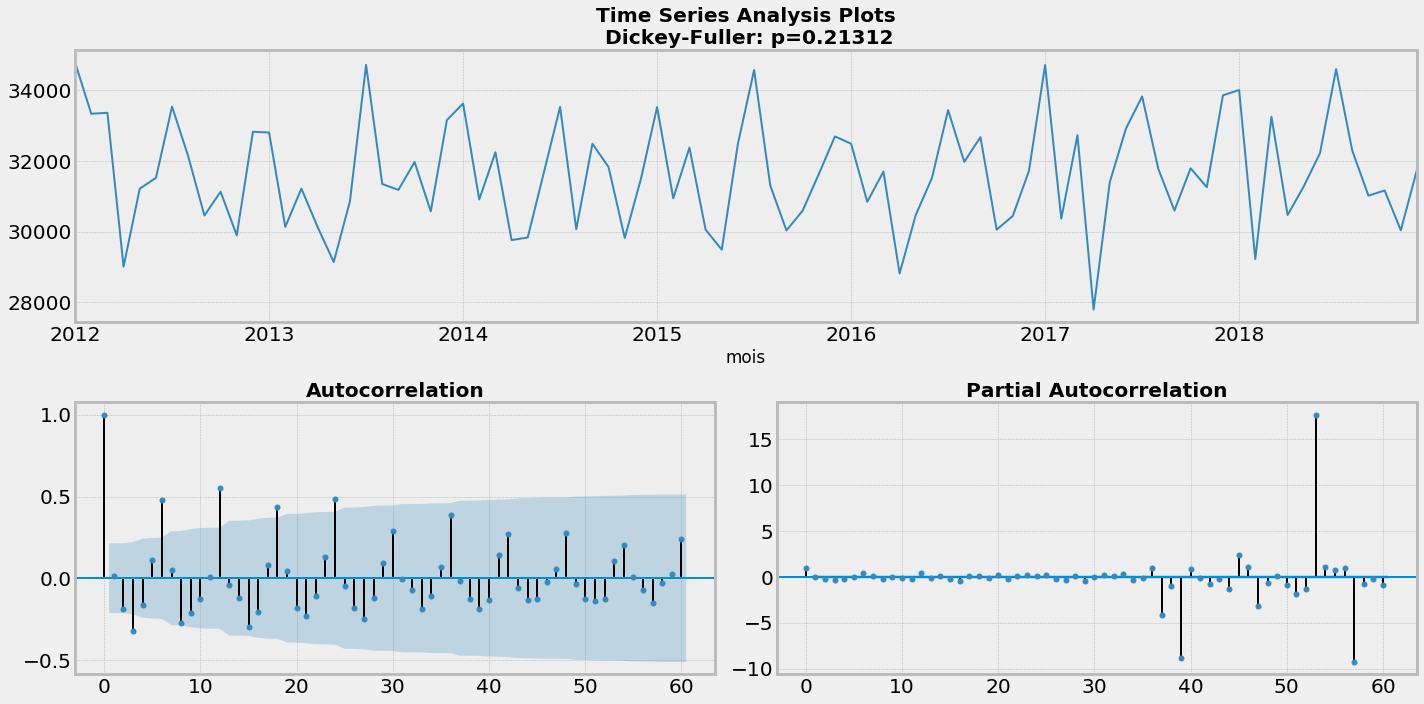

In [50]:
#Test de Dickey–Fuller avec Autocorrélogrammes ACF et PACF
tsplot(df['conso_corr'], lags=60)

La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. Confirmation également par le test de Dickey-Fuller portant pour hypothèse nulle la non-stationnarité de la série, ne pouvant pas être rejetée. On effectue donc une première différenciation. 

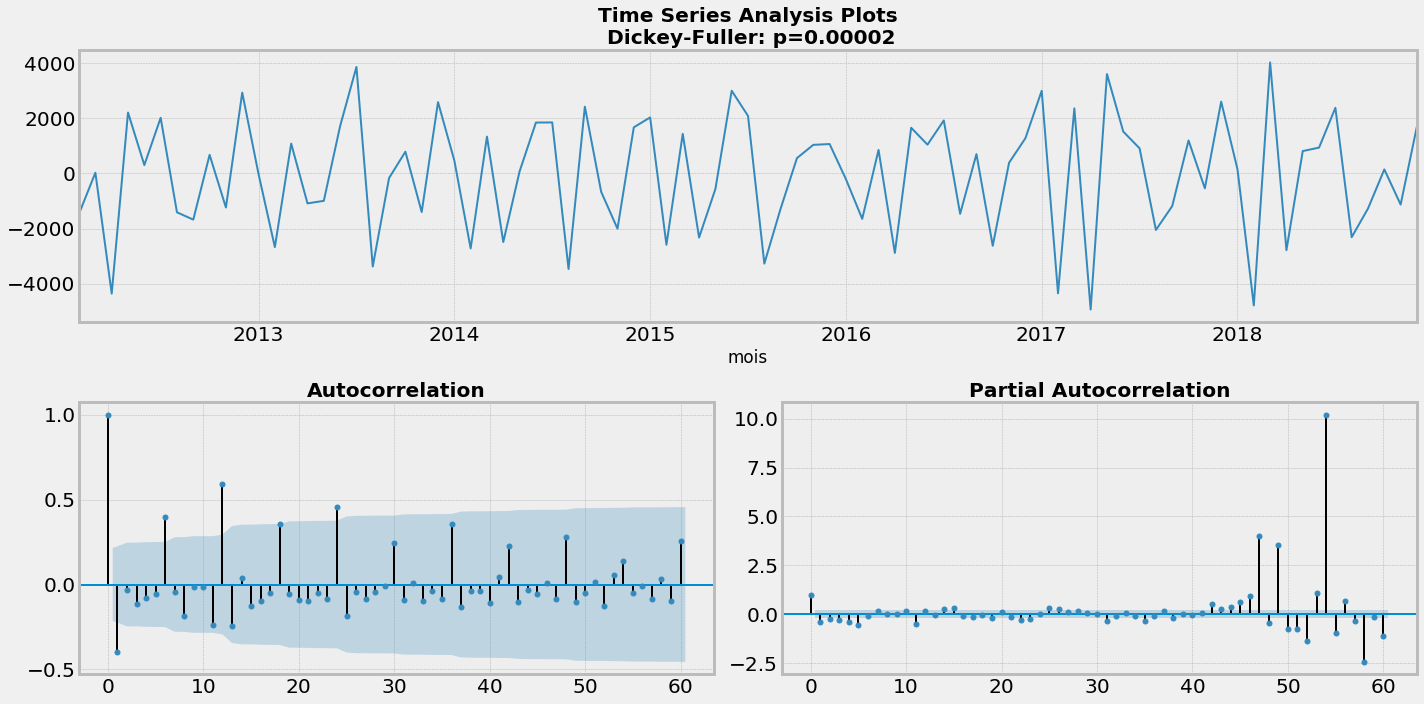

In [51]:
#Première différenciation d'ordre 1 par la méthode .shift()
df_diff1 = df['conso_corr'] - df['conso_corr'].shift(1)
tsplot(df_diff1[1:], lags=60)

La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 12. On effectue cette fois la différenciation d'ordre 12.

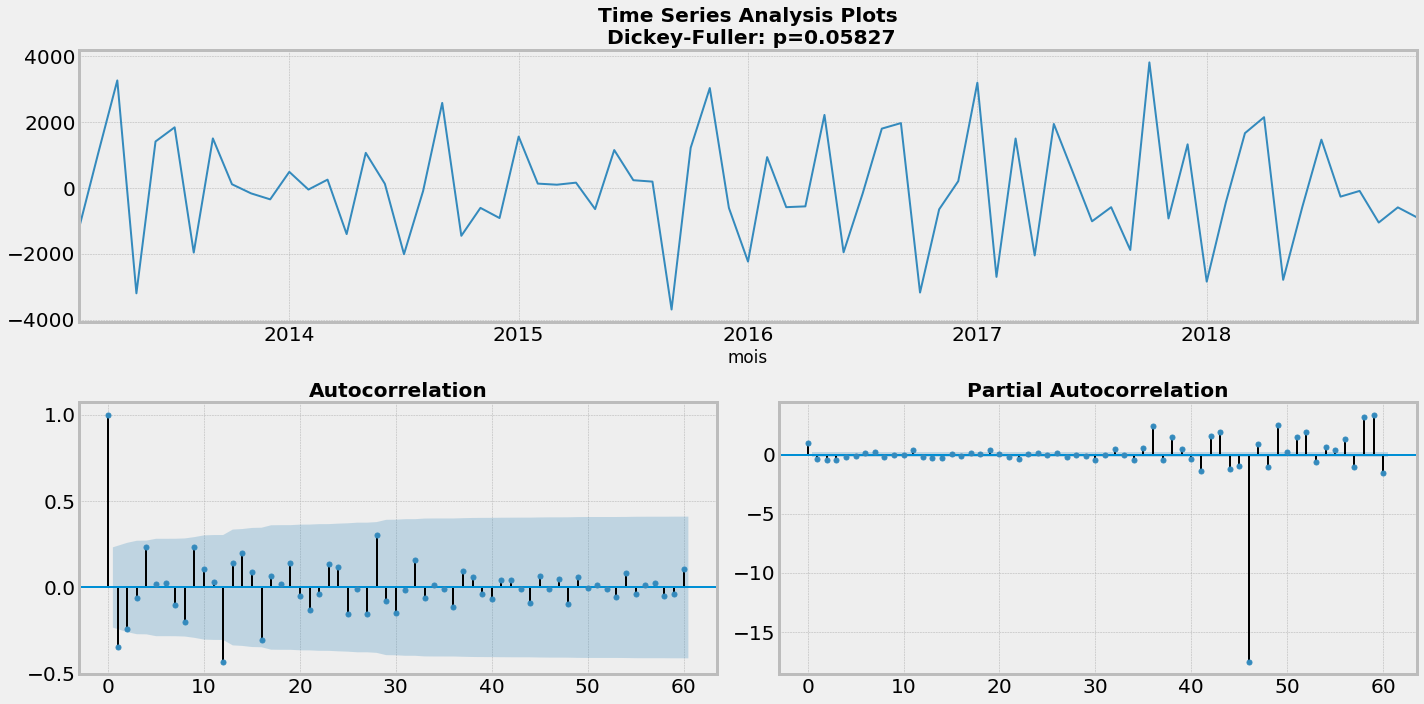

In [52]:
#Seconde différenciation d'ordre 12 
df_diff1_12 = df_diff1 - df_diff1.shift(12)
tsplot(df_diff1_12[13:], lags=60)

Cette fois-ci les résultats sont satisfaisants, nous pouvons nous appuyer sur les autocorrélogrammes simple et partiels estimés.

### Génération d'une configuration optimale SARIMA :

L’identification des combinaisons sera faite par l’approche d’optimisation des polynômes AR et MA. Nous cherchons à minimiser le critère d’information d’Akaike AIC pour déterminer les ordres optimaux. La blancheur et normalité du résidu est également un critère à prendre en compte. 

In [53]:
#Détermination du meilleur modèle de prévision 
from time import time
DUREE_PREDITE = 12 #prédiction sur 12 mois
troncature = DUREE_PREDITE
y = df['conso_corr']
y_prevision = y[-troncature:]

#Calcul de toutes les combinaisons de p, d et q
pdq_list = list(itertools.product(range(3),
                             range(2), 
                             range(3)
           ))

#Calcul de toutes les combinaisons de P, D et Q
PDQ_list = [ (*val, 12) for val in list(itertools.product(
                            range(3), 
                            range(2), 
                            range(3))
            )]


#Nombre de configurations total pour un modèle SARIMA
n = len(pdq_list) * len(PDQ_list)

#Dataframe pour stockage des valeurs
results_SARIMA = pd.DataFrame({'modele':[], 'aic':[], 'bic':[], 'ljungbox':[], 'pvalues':[]})
counter = 1
s_time = time()

#Itération sur toutes les combinaisons
for pdq in pdq_list:
    for PDQ in PDQ_list:
        try:
            #Instanciation et entrainement du modèle SARIMA
            mod = SARIMAX(np.asarray(y), order = pdq, seasonal_order = PDQ, 
                          enforce_stationarity=False, enforce_invertibility=False)
            result = mod.fit()
                    
            #Intégration des indicateurs dans le précédent dataframe
            results_SARIMA = results_SARIMA.append({'modele':f"{pdq}x{PDQ}", 
                            'aic': result.aic, 
                            'bic': result.bic,
                            'ljungbox': acorr_ljungbox(result.resid, lags=12)[1].mean(),
                            'pvalues': result.pvalues.min()}, 
                            ignore_index=True)
        except:
            continue
            
        clear_output(' ')
        print(f"{counter}/{n} - {time() - s_time:.0f}s")
        counter += 1

324/324 - 174s


**A partir des 324 modèles**, une sélection plus fine peut-être établie en triant ceux uniquement qui répondent aux critères suivants :

In [54]:
#Sélection des modèles SARIMA les plus optimaux selon les tests de significativité des paramètres 
#et de blancheur du résidu sont validés au niveau 5%
results_SARIMA_filter = results_SARIMA[(results_SARIMA['ljungbox'] > 0.05)]
results_SARIMA_filter = results_SARIMA_filter[results_SARIMA_filter['pvalues'] < 0.05]

In [55]:
#Utilisation de la fonction .rank() pour déterminer la position de chaque modèle selon la minimisation AIC / BIC
results_SARIMA_filter['rank_aic'] = results_SARIMA_filter['aic'].rank(ascending=True)
results_SARIMA_filter['rank_bic'] = results_SARIMA_filter['bic'].rank(ascending=True)

In [56]:
#Visualisation des 30 modèles les plus performants sur les 324 initiaux
def highlight_greaterthan(x):
    if x.rank_aic == 25:
        return ['background-color: #2399f9']*7
    else:
        return ['background-color: None']*7

results_SARIMA_filter.sort_values('rank_aic', ascending=True)[:30].style.apply(highlight_greaterthan, axis=1)


,modele,aic,bic,ljungbox,pvalues,rank_aic,rank_bic
95,"(0, 1, 2)x(0, 1, 2, 12)",738.406,747.326,0.908576,8.30183e-08,1,1
101,"(0, 1, 2)x(1, 1, 2, 12)",739.429,750.134,0.940723,6.27088e-07,2,2
203,"(1, 1, 2)x(0, 1, 2, 12)",739.864,750.57,0.88025,2.89429e-07,3,3
107,"(0, 1, 2)x(2, 1, 2, 12)",741.166,753.655,0.943089,1.08234e-14,4,4
209,"(1, 1, 2)x(1, 1, 2, 12)",741.212,753.702,0.902335,0.00180649,5,5
311,"(2, 1, 2)x(0, 1, 2, 12)",741.536,754.025,0.916196,2.11293e-06,6,6
215,"(1, 1, 2)x(2, 1, 2, 12)",743.026,757.299,0.917215,0.00202121,7,7
317,"(2, 1, 2)x(1, 1, 2, 12)",744.485,758.758,0.0575169,1.70102e-05,8,8
323,"(2, 1, 2)x(2, 1, 2, 12)",748.675,764.732,0.916311,0.0245864,9,11
83,"(0, 1, 1)x(1, 1, 2, 12)",755.117,764.15,0.962951,0.0161954,10,10


Selon la minimisation du critère AIC et BIC , **le modèle (1, 1, 1)x(2, 1, 1, 12) ressort comme étant le plus optimal.** Ce choix a été fait après plusieurs tests sur plusieurs modèles, il ressort comme étant le plus performant en tenant compte également de la significativité des paramètres, ainsi que la blancheur du résidu estimée à l'aide du test de Ljung–Box. Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.

In [57]:
#Instanciation et entrainement du modèle SARIMA via statsmodels
model = SARIMAX(np.asarray(y), order=(1,1,1), seasonal_order=(2,1,1,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -615.377
Date:                            Tue, 18 Aug 2020   AIC                           1242.754
Time:                                    10:06:54   BIC                           1256.331
Sample:                                         0   HQIC                          1248.153
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5840      0.155      3.760      0.000       0.280       0.888
ma.L1         -0.7093      0.149   

#### Normalité des résidus :
Dans le cadre de prévisions, il convient de vérifier la normalité des résidus pour tester l'adéquation de nos modèles. La normalité peut-être détectée de façon graphique, mais des tests statistiques amènent un point de vue objectif non négligeable.

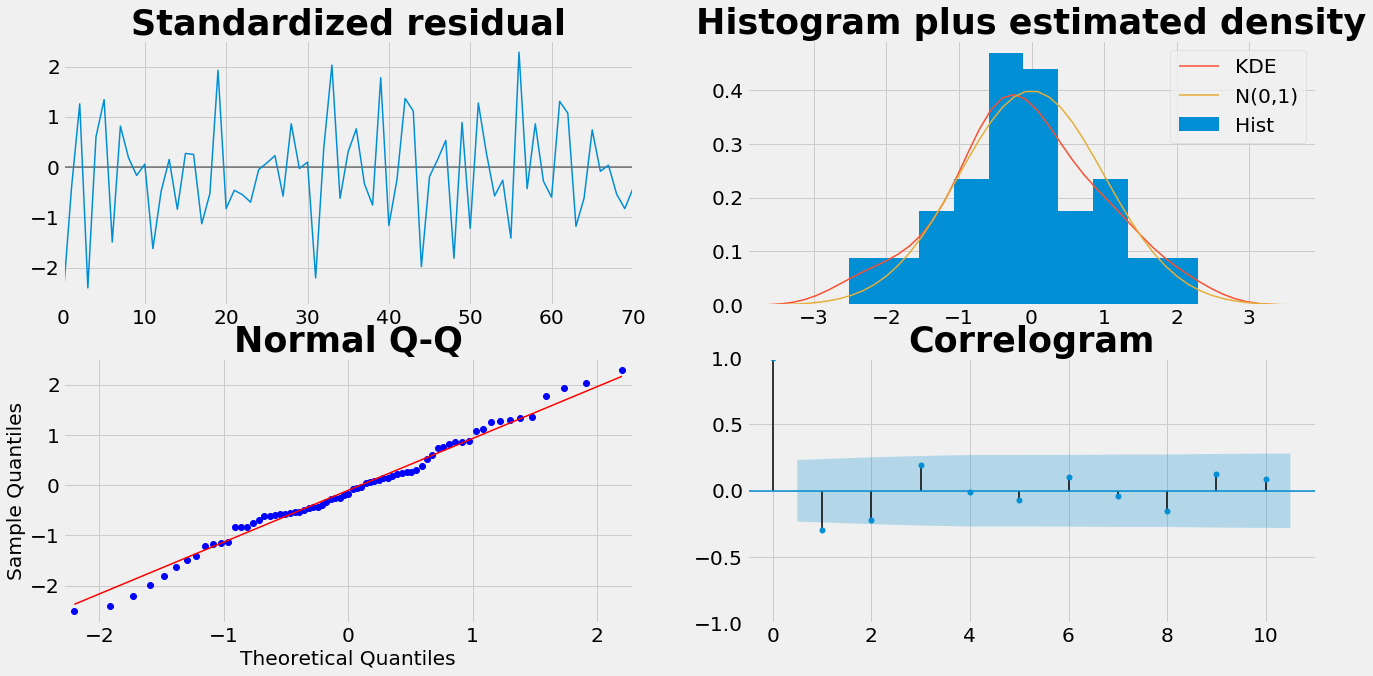

In [58]:
#La fonction .plot_diagnostics() permet d'établir un diagnostic rapide du modèle SARIMA identifié  
fig = results.plot_diagnostics()

La représentation "Standardized residual" et "Correlogram" confirment qu'il n'y a pas de corrélation des résidus. Les résidus sont normalement distribués KDE vs distribution normale - N (0,1). La distribution ordonnée des résidus  représentée par le du Q-Q plot est globalement satisfaisant, il y a quand même des petites divergences vers les queues de distribution. Il est intéressant de coupler l'approche visuelle par des tests statistiques.

In [59]:
#Test de Shapiro-Wilk
from scipy.stats import shapiro
shapiro(results.resid)

(0.4359845519065857, 2.3092423659955535e-16)

In [60]:
#Test de Jarque-Bera
results.test_normality("jarquebera")[0][1]

0.9845379751517565

Ce test ne prend pas en compte les premiers résidus d'après la documentation, ce qui rappelle le premier constat du Q-Q plot, les premiers résidus divergent légèrement d'un schéma gaussien, le test ne les prend pas en compte est devient donc concluant sans pouvoir rejeter l'hypothèse nulle de normalité des résidus dans ce cadre précis.

Ici, l'hypothèse de normalité est remise en cause par Shapiro (p-value < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante permettent de dire que **les résultats obtenus par le modèle ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.

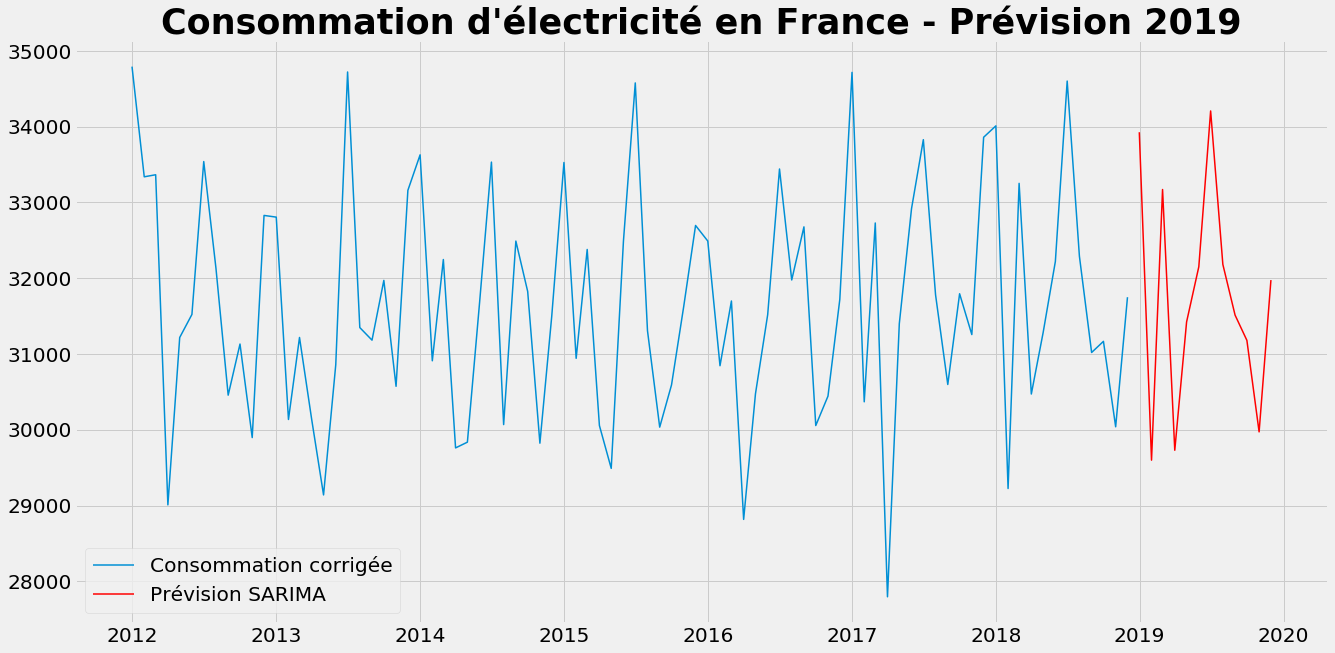

In [61]:
#Visualisation de la prévision à 12 mois par la méthode SARIMA
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean

plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')

plt.title("Consommation d'électricité en France - Prévision 2019")
plt.legend()

plt.savefig('p9_graphic/sarima_prevision2019.jpg')
plt.show() 

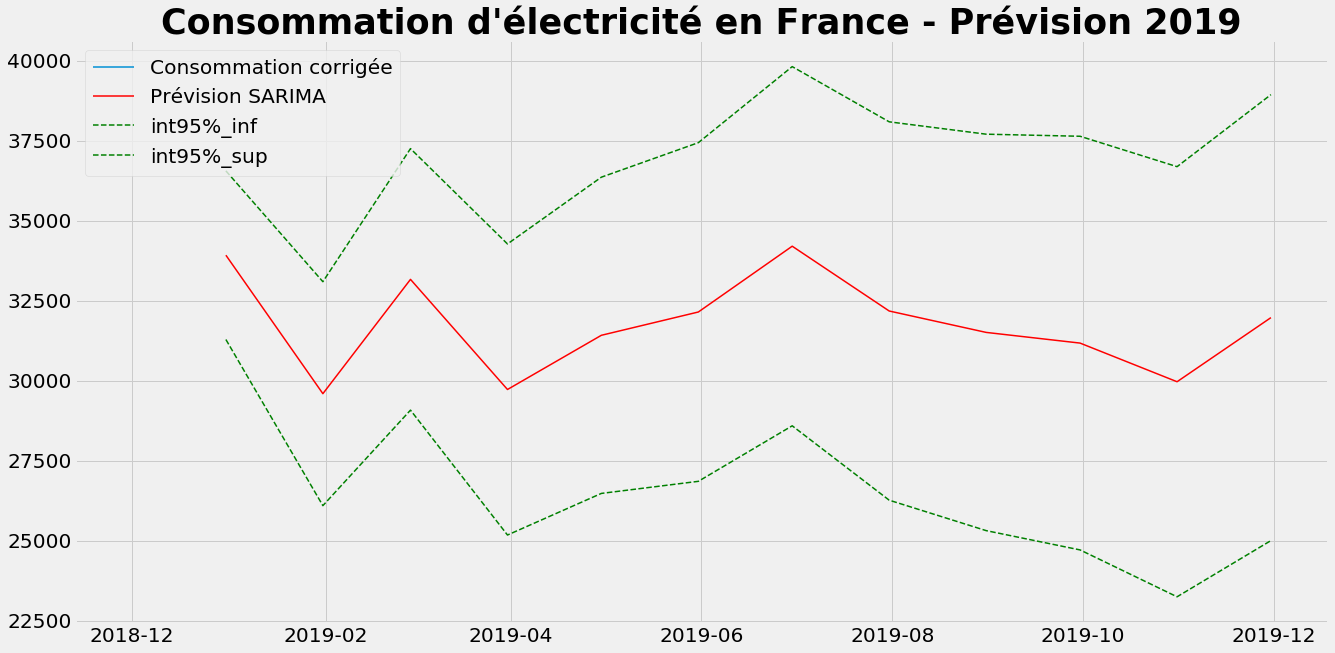

In [62]:
#Visualisation des intervalles de confiance sur la prévision à 12 mois
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean

pred_l = [(elt[0]) for elt in pred_model.conf_int(alpha=0.05)]
pred_u = [(elt[1]) for elt in pred_model.conf_int(alpha=0.05)]

plt.plot(df['conso_corr'].iloc[-1:], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), 
         pred_l, color='g', linestyle='--', label='int95%_inf')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), 
         pred_u, color='g', linestyle='--', label='int95%_sup')

plt.title("Consommation d'électricité en France - Prévision 2019")
plt.legend()

plt.savefig('p9_graphic/sarima_prevision2019_int95.jpg')
plt.show() 

Un intervalle de confiance globalement satisfaisant. Notons qu'il semble y avoir un niveau d'incertitude plus marqué sur une durée de prévision plus longue.

### Analyse a posteriori
On tronque la série de l’année 2018, qu’on cherche ensuite à prévoir à partir de l’historique 2012-2017.

In [63]:
#Troncature des données sur les années 2017 et 2018
df_tronc = df[:'2017'] 
x_prevision = df['2018':]  

In [64]:
model_tronc = SARIMAX(np.asarray(df_tronc['conso_corr']), order=(1,1,1), seasonal_order=(2,1,1,12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_tronc.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -514.263
Date:                            Tue, 18 Aug 2020   AIC                           1040.526
Time:                                    10:06:57   BIC                           1052.991
Sample:                                         0   HQIC                          1045.392
                                             - 72                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5952      0.189      3.142      0.002       0.224       0.966
ma.L1         -0.7049      0.181   

Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.

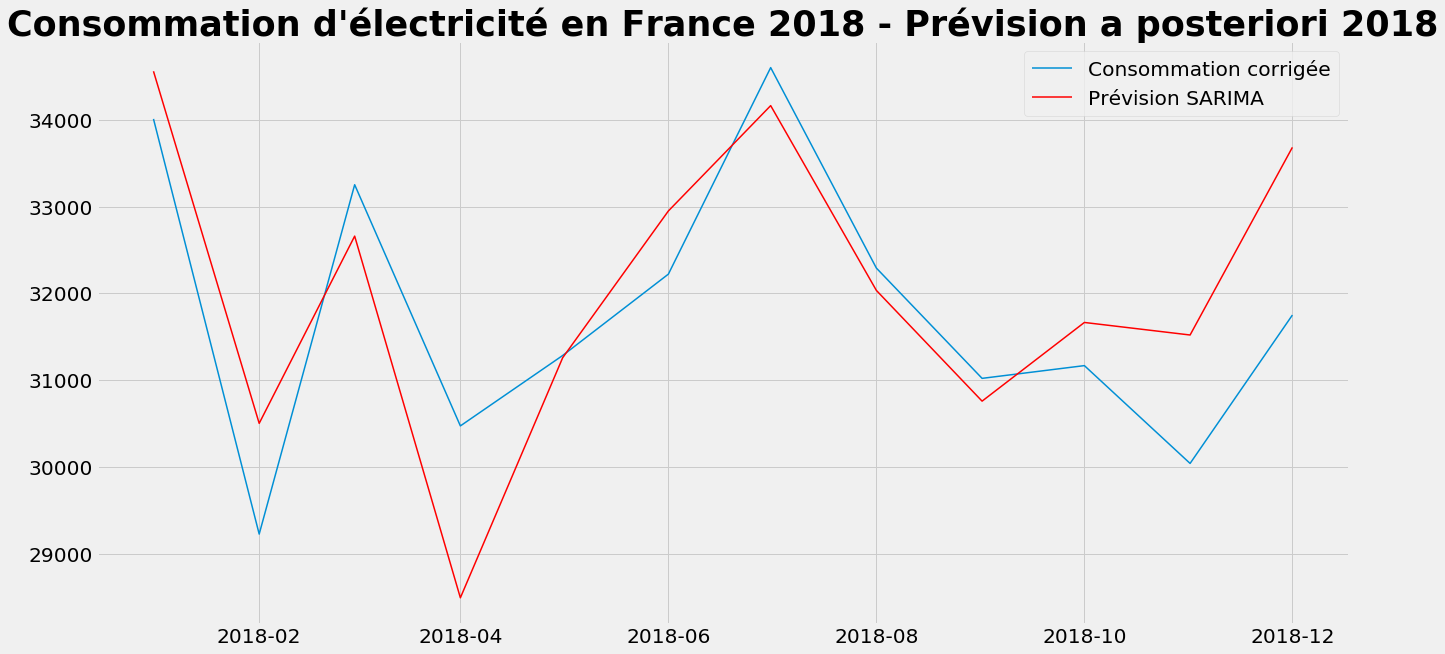

In [65]:
#Visualisation par restriction sur l'année 2018
pred_model_tronc = results_tronc.get_forecast(12)
pred_tronc = pred_model_tronc.predicted_mean

plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(x_prevision.index, pred_tronc, color='r', label='Prévision SARIMA')


plt.title("Consommation d'électricité en France 2018 - Prévision a posteriori 2018")
        
plt.legend()
plt.savefig("p9_graphic/prevision_visu20182018_sarima_aposteriori.png")
plt.show()

In [66]:
mape = round((np.abs(1-pred_tronc/x_prevision["conso_corr"])).mean()*100, 2)
mape

2.68

Prévision à 12 mois performante, sans s'arrêter strictement au MAPE, la méthode SARIMA semble mieux prendre en compte les impacts saisonniers (pics et creux).

In [67]:
#Troncature des données pour une prévision a posteriori de 24 mois
df_tronc = df[:'2016']
x_prevision = df['2017':]

In [68]:
model_tronc = SARIMAX(np.asarray(df_tronc['conso_corr']), order=(1,1,1), seasonal_order=(2,1,1,12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_tronc.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -408.329
Date:                            Tue, 18 Aug 2020   AIC                            828.658
Time:                                    10:06:59   BIC                            839.759
Sample:                                         0   HQIC                           832.835
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6600      0.190      3.474      0.001       0.288       1.032
ma.L1         -0.7504      0.178   

Notons qu'il n'est pas facile de tester une prévision a posteriori sur 24 mois sans avoir à réoptimiser le modèle. Ici, un paramètre AR saisonnier n'est plus significatif, il serait donc nécessaire de le retrirer pour pouvoir ré-évaluer la prédiction. Ici, il n'est pas utile d'aller plus loin dans cette démarche de ré-optimisation du modèle, celui choisi satisfait nos objectifs de prédiction à 12 mois.

### Conclusion
Dans cette étude, nous avons utilisé les données mensuelles de consommation d’électricité en France, ainsi que l'effet de température lié au chauffage pour tester des modèles de prévison de cette consommation à 12 mois. L’exploration de ces données nous a révélé des caracteristiques tels que la non stationnarité de la série de consommation d’électricité et sa très forte inertie (autocorrélation forte et longue). Deux processus de différenciation ont été nécessaire pour rendre la série stationnaire. 

Les prévisions par la méthode de lissage exponentiel Holt-Winters et SARIMA sont globablement satisfaisantes, avec l’erreur absolue moyenne en pourcentage au dessous de 3%. Par ailleurs, le modèle SARIMA sera retenu prioritairement pour prédire la consommation d’électricité plus ponctuelle (à court terme), il sera plus performant et plus robuste dans des prévisions devant prendre en compte de forts impacts saisonniers. 

[Retour vers la page notebook précédent traitant la correction de la consommation de l'effet de température](https://github.com/nalron/project_electricity_forecasting/blob/french_version/p9_notebook02.ipynb)